In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 08d
### Neural Network with :
- pytorch implementation Custom Dataset Class with loader
- One hidden layer 
- ${Tanh}$ activation function
- multi-class - Fashion MNIST dataset (all 60000 images)


In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'pytorch_fashion'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df['test_loss'] == hist_df['test_loss'].min()]
    
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = 'epoch', y = ['loss', 'test_loss'], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1]['loss'],
                           loss_df.iloc[-1]['test_loss']) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best["test_loss"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_loss"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy()+0.01, best["test_loss"].to_numpy()[0]-0.01), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = 'epoch', y = ['acc', 'test_acc'], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1]['acc'],
                           loss_df.iloc[-1]['test_acc']) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best["test_acc"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]+0.01), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## All about CUDA

In [6]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce GTX 1650


In [7]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Load Data Set

Loading Fashion MNIST Dataset

<img src = '../../images/pytorch_fashion_mnist.png' alt = 'pytorch_fashion_mnist'>

In [8]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [9]:
labels= {0 : 'T-shirt/top',
         1  : 'Trouser',
         2  : 'Pullover',
         3 : 'Dress',
         4 : 'Coat',
         5 : 'Sandal',
         6 : 'Shirt',
         7 : 'Sneaker',
         8 : 'Bag',
         9 : 'Ankle boot'}

## Dataset Class

In [10]:
'''
In this code, we define a custom dataset called FashionDS 
that takes a DataFrame as input. 

'''

class FashionDS(Dataset):
    def __init__(self, dataframe, device = device):
        self.df = dataframe
        self.device = device
        feat = self.df.drop('label', axis = 1).to_numpy()
        self.features = feat / 255.0

        self.labels = self.df.label.to_numpy()

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        labels = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        labels = torch.tensor(labels, dtype=torch.int64, device=self.device)
        
        return features, labels

In [11]:
# convert to datasets
train_ds = FashionDS(train_df)
test_ds = FashionDS(test_df)

In [12]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Verify Data
Lets check if we are getting proper data

In [13]:
# get one batch
images, targets = next(iter(train_loader))

# move them to CPU and convert to numpy
images = images.cpu().numpy()
targets = targets.cpu().numpy()

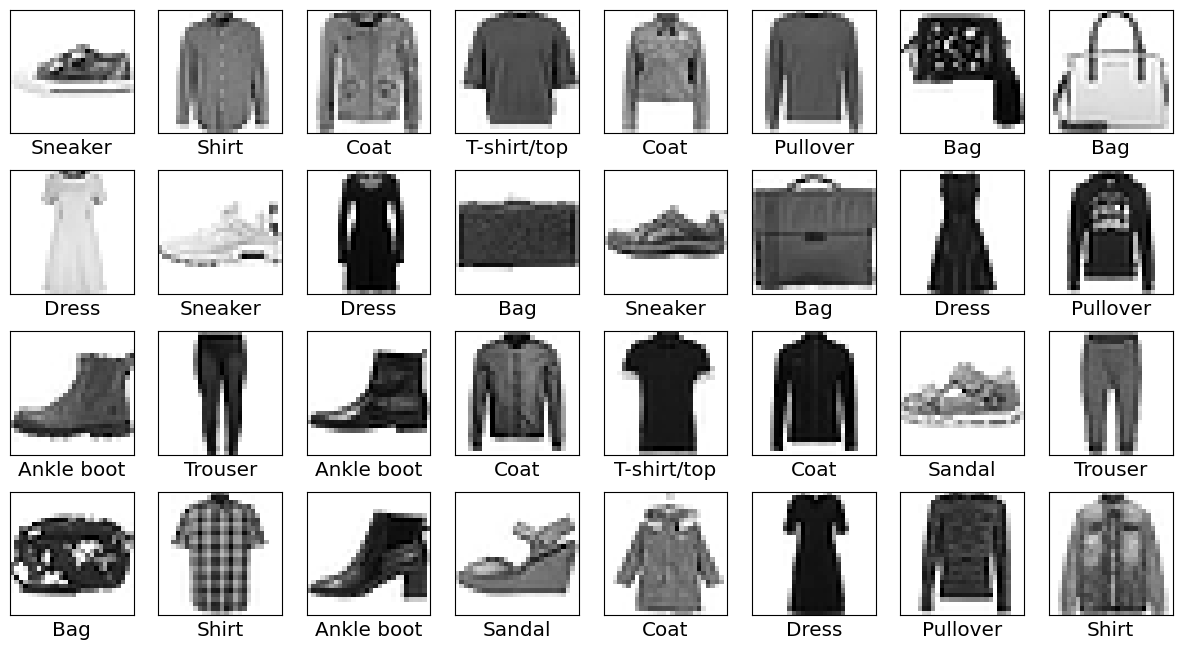

In [14]:
plt.figure(figsize=(15,8))

for i in range(32):
    
    plt.subplot(4,8,i+1)
    
    plt.xticks([])
    
    plt.yticks([])
    
    plt.grid(False)
    
    plt.imshow(images[i].reshape(28,28,1), cmap=plt.cm.binary)
    
    plt.xlabel(labels[targets[i]])

plt.show()

## NN Model

In [15]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,392)
        self.layer2 = nn.Linear(392, 10)
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(input_dim=train_df.shape[1]-1).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (layer2): Linear(in_features=392, out_features=10, bias=True)
)


In [16]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, targets = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, targets)
        batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, targets = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, targets)

            batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:1.6622, test:1.6210 | Acc - train:0.8050, test:0.8436
At epoch 1 | Loss - train:1.6207, test:1.6114 | Acc - train:0.8420, test:0.8508
At epoch 2 | Loss - train:1.6091, test:1.6048 | Acc - train:0.8529, test:0.8574
At epoch 3 | Loss - train:1.6028, test:1.6086 | Acc - train:0.8590, test:0.8531
At epoch 4 | Loss - train:1.5962, test:1.5967 | Acc - train:0.8659, test:0.8657
At epoch 5 | Loss - train:1.5900, test:1.6012 | Acc - train:0.8720, test:0.8607
At epoch 6 | Loss - train:1.5876, test:1.5853 | Acc - train:0.8740, test:0.8789
At epoch 7 | Loss - train:1.5830, test:1.5881 | Acc - train:0.8793, test:0.8739
At epoch 8 | Loss - train:1.5801, test:1.5898 | Acc - train:0.8827, test:0.8741
At epoch 9 | Loss - train:1.5778, test:1.5853 | Acc - train:0.8851, test:0.8756
At epoch 10 | Loss - train:1.5758, test:1.5838 | Acc - train:0.8868, test:0.8790
At epoch 11 | Loss - train:1.5735, test:1.5870 | Acc - train:0.8895, test:0.8738
At epoch 12 | Loss - train:1.5713, tes

In [17]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.662154,1.620961,0.805033,0.8436
1,1,1.620730,1.611380,0.841967,0.8508
2,2,1.609058,1.604803,0.852950,0.8574
3,3,1.602798,1.608613,0.858983,0.8531
4,4,1.596222,1.596707,0.865917,0.8657


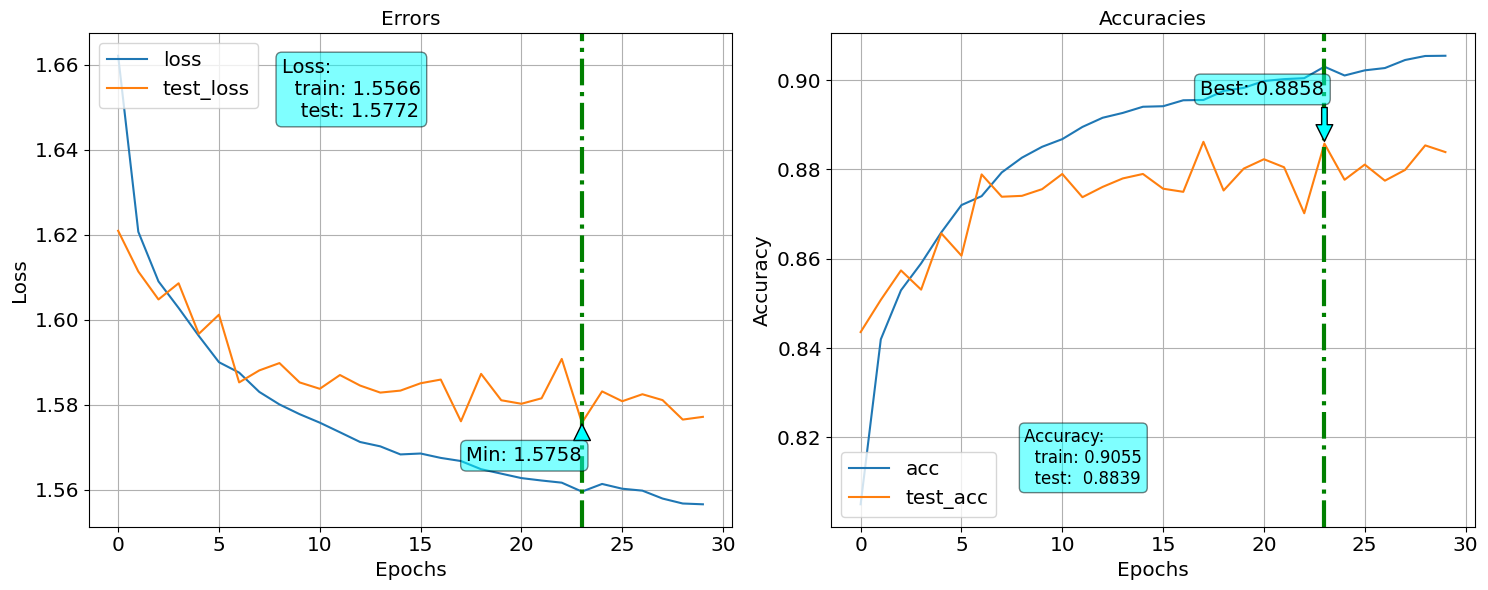

In [18]:
plot_hist(loss_df)

In [19]:
# we transform all our features with the scaler
X_scaled_all = train_df.drop('label', axis = 1).to_numpy() / 255.

# transform in tensors
X_scaled_all_tensors = torch.tensor(X_scaled_all, dtype=torch.float32).to(device)

# we set the model in inference mode and create the predictions
with torch.inference_mode():
    logits = net(X_scaled_all_tensors)
    predictions = logits.argmax(dim = 1)
    
train_df['pred'] = predictions.cpu().numpy().flatten()

In [20]:
y_pred = train_df['pred'].to_numpy()
y_train = train_df['label']
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

Accuracy score on Train Data : 0.9096166666666666


In [21]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      6000
           1       0.99      0.98      0.99      6000
           2       0.86      0.81      0.83      6000
           3       0.86      0.94      0.90      6000
           4       0.81      0.84      0.82      6000
           5       0.99      0.98      0.99      6000
           6       0.79      0.74      0.77      6000
           7       0.96      0.97      0.97      6000
           8       0.99      0.98      0.98      6000
           9       0.97      0.98      0.97      6000

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



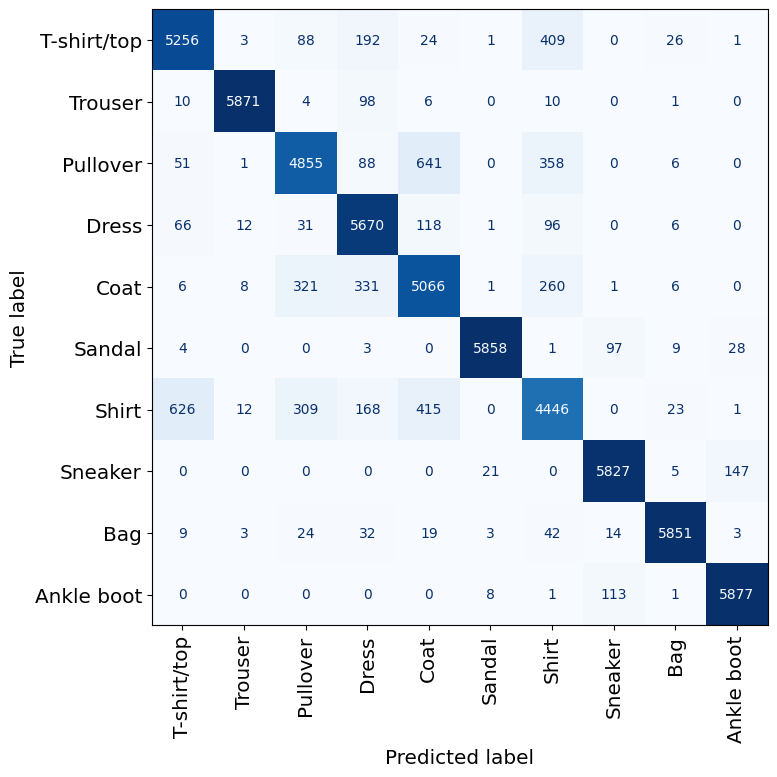

In [22]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())

fig, ax = plt.subplots(figsize = (8,8))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation='vertical')
plt.show();


In [23]:
# we transform all our features with the scaler
X_scaled_all = test_df.drop('label', axis = 1).to_numpy() / 255.

# transform in tensors
X_scaled_all_tensors = torch.tensor(X_scaled_all, dtype=torch.float32).to(device)

# we set the model in inference mode and create the predictions
with torch.inference_mode():
    logits = net(X_scaled_all_tensors)
    predictions = logits.argmax(dim = 1)
    
test_df['pred'] = predictions.cpu().numpy().flatten()

In [24]:
y_pred = test_df['pred'].to_numpy()
y_test = test_df['label']
print('Accuracy score on Train Data :', accuracy_score(y_test, y_pred))

Accuracy score on Train Data : 0.8839


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.76      0.80      1000
           3       0.85      0.94      0.89      1000
           4       0.79      0.84      0.81      1000
           5       0.98      0.92      0.95      1000
           6       0.72      0.69      0.71      1000
           7       0.92      0.94      0.93      1000
           8       0.98      0.96      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



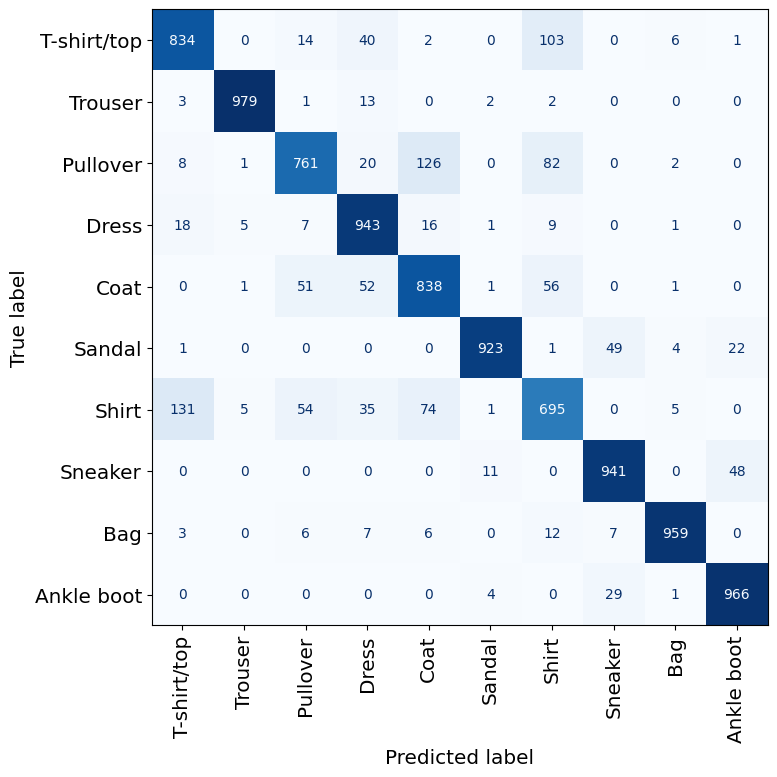

In [26]:
cm  = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())

fig, ax = plt.subplots(figsize = (8,8))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation='vertical')
plt.show();

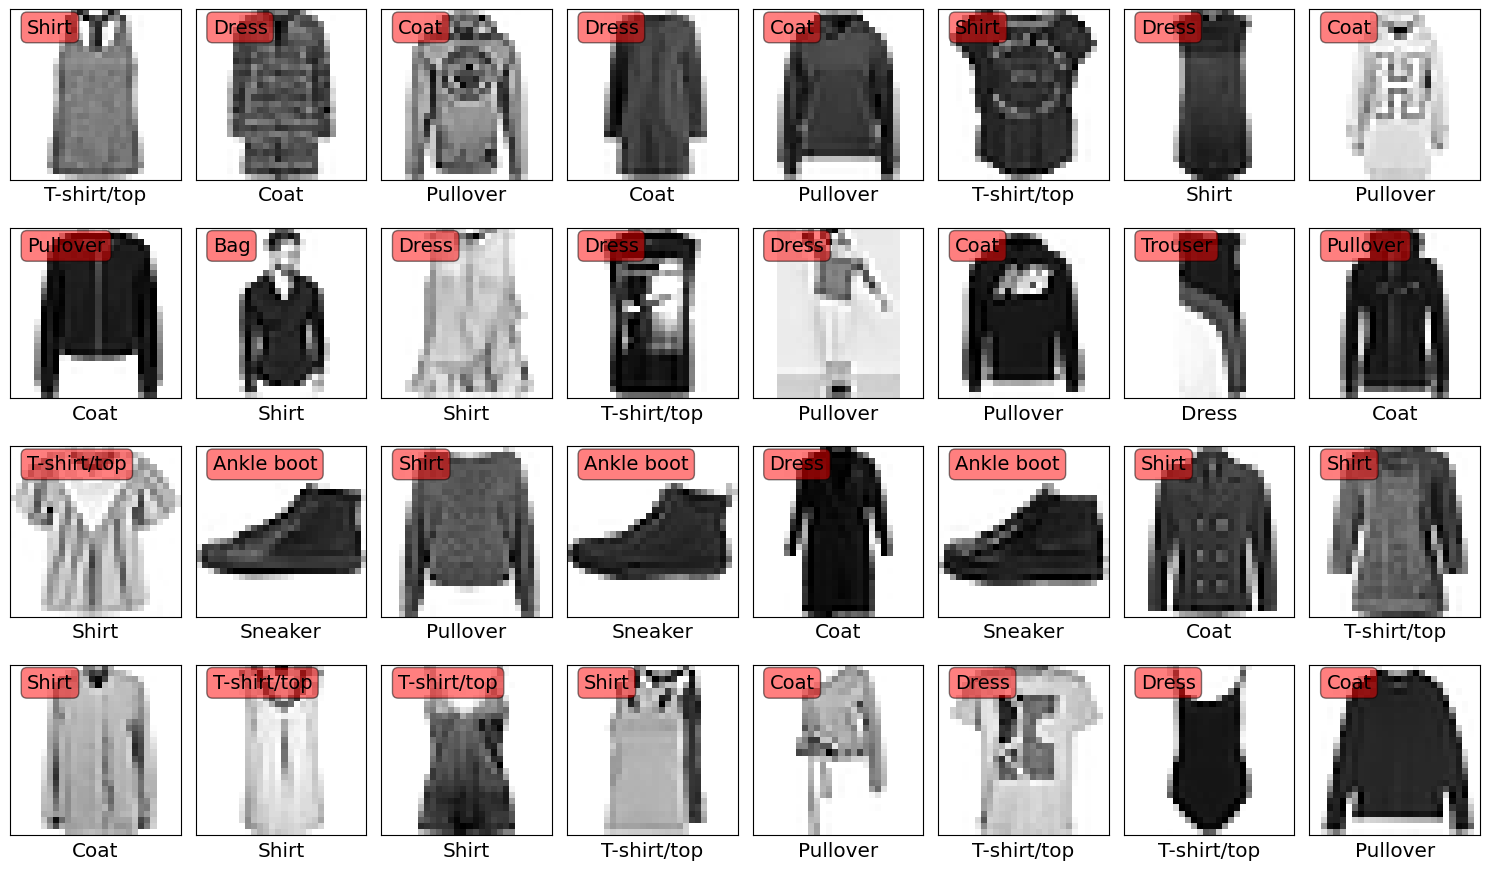

In [27]:
test_df['pred'] = y_pred # Add prediction column
plot_df = test_df[test_df['label'] != test_df['pred']] # pick rows where predictions are wrong

plot_df = plot_df.sample(n=32) # sample 32 records

y_test_plot = plot_df.label.to_numpy()
y_pred_plot = plot_df.pred.to_numpy()

X_plot = plot_df.drop(['label', 'pred'], axis = 1).to_numpy() / 255.


plt.figure(figsize=(15,9))


for i in range(32):
    ax = plt.subplot(4,8,i+1)
    # properties  matplotlib.patch.Patch 
    if y_test_plot[i]!= y_pred_plot[i]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_plot[i].reshape(28,28,1), cmap=plt.cm.binary)
    plt.xlabel(labels[y_test_plot[i]])
    # place a text box in upper middle in axes coords
    ax.text(0.1, 0.95, labels[y_pred_plot[i]], transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.tight_layout()
plt.show()